In [1]:
from collections import defaultdict
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


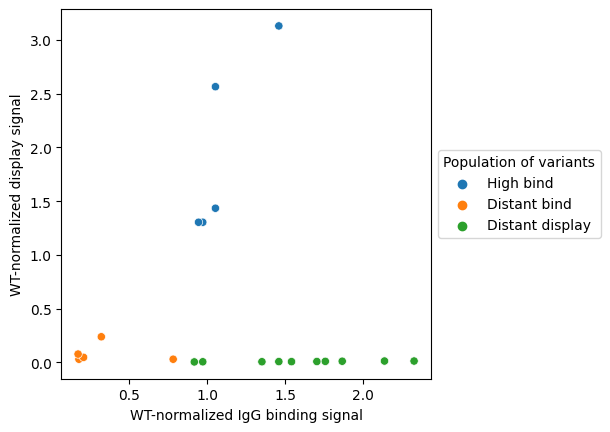

In [2]:
# fig 4a
seq_order = pd.read_csv('data/seqs_order_df.csv', index_col=0)
ysd_measure = pd.read_csv('data/ysd_bind_display.csv')
for col in ysd_measure.columns:
    ysd_measure[col] = [item.replace('*', '') if isinstance(item, str) else item 
                        for item in ysd_measure[col]]
    if col in ['MFU IgG Bind', 'MFU Display']:
        wt_val = ysd_measure.loc[ysd_measure['Clone']=='wt'].iloc[0][col]
        ysd_measure[col] = [float(item)/float(wt_val) for item in ysd_measure[col]]
seq_order['ysd_plasmid'] = [str(i) for i in range(25, 25+len(seq_order))]
seq_order['group'] = ['High bind']*5 + ['Distant bind']*5 + ['Distant display']*10
ysd_measure = pd.merge(ysd_measure, seq_order, left_on='Clone', right_on='ysd_plasmid')

sns.scatterplot(data=ysd_measure, x='MFU Display', y='MFU IgG Bind', hue='group')
plt.xlabel('WT-normalized IgG binding signal')
plt.ylabel('WT-normalized display signal')
plt.legend(title='Population of variants', loc='center left', bbox_to_anchor=(1, 0.5))
ax = plt.gca()
ax.set_box_aspect(1)
plt.savefig('plots/yeast_display_low_throughput.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


,clones,Kd,Max Signal
0,WT,1.12,8.68
1,Design10,1.02,11.93
2,FCN-5,0.99,13.13
3,EnsC-5,1.98,14.27
4,CNN-10,1.04,20.38
5,EnsC-20,7.67,7.80


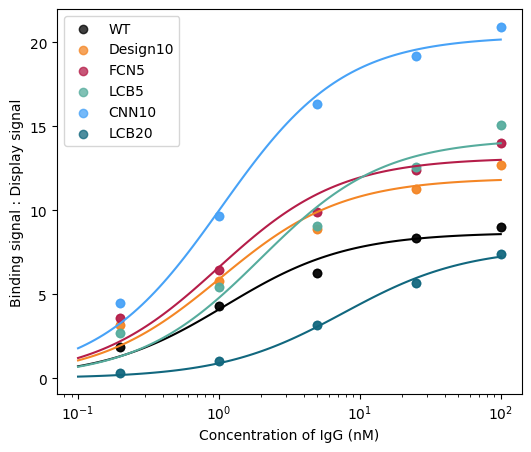

In [3]:
# fig 4b
files = ['data/ysd_bind1.csv', 'data/ysd_bind2.csv']
clones = ['WT', 'Design10', 'FCN-5', 'EnsC-5', 'CNN-10', 'EnsC-20']

bind_data = defaultdict(list)
for file in files:
    with open(file, 'r') as f:
        raw_data = [row.split(',') for row in f.read().split('\n')]
        for row in raw_data[1:]:
            for i in range(1, len(raw_data[0])):
                bind_data[row[0]].append([float(raw_data[0][i]), float(row[i])])
        
def fraction_bound(conc, kd, max_res):
    return conc/(conc+kd)*max_res

colors = ['k', '#f48625', '#B51D49', '#56AC9D', '#47A2F7', '#11677E']

plt.figure(figsize=(6,5))

kds = []
max_resps = []
for (clone, data), color in zip(bind_data.items(), colors):
    titers = list(zip(*data))[0]
    bind_sigs = list(zip(*data))[1]
    plt.scatter(titers, bind_sigs, label=clone, color=color, alpha=0.75)
    popt, pcov = curve_fit(fraction_bound, titers, bind_sigs, p0=[5, 100])
    max_resps.append(round(popt[1], 2))
    kds.append(round(popt[0], 2))
    fit_concentrations = np.logspace(-1, 2, 100)
    plt.plot(fit_concentrations, fraction_bound(fit_concentrations, *popt), color=color)
    
plt.xscale('log')
plt.xlabel('Concentration of IgG (nM)')
plt.ylabel('Binding signal : Display signal')
plt.legend()
plt.savefig('plots/binding_curves.eps', format='eps')

pd.DataFrame({'clones':clones, 'Kd':kds, 'Max Signal':max_resps})